# Robustness certification experiment for insurance dataset

In [68]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [70]:
def load_ins():
    # fetch dataset
    auto_mpg = pd.read_csv('insurance.csv').drop('sex', axis=1).drop('smoker', axis=1).drop('region', axis=1).replace('?', np.nan)
    features = ['age', 'bmi', 'children']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['charges']
    
    # with this random seed, no null value is included in the test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test


# first impute the data and make it hypothetically clean
def load_ins_cleaned():
    # fetch dataset
    auto_mpg = pd.read_csv('insurance.csv').drop('sex', axis=1).drop('smoker', axis=1).drop('region', axis=1).replace('?', np.nan)
    features = ['age', 'bmi', 'children']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['charges']
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [71]:
X_train, X_test, y_train, y_test = load_ins_cleaned()

In [72]:
X_train

,age,bmi,children
0,53.0,26.600,0.0
1,53.0,21.400,1.0
2,18.0,37.290,0.0
3,60.0,24.035,0.0
4,45.0,33.700,1.0
...,...,...,...
1065,60.0,28.900,0.0
1066,26.0,29.355,2.0
1067,51.0,34.960,2.0
1068,40.0,22.220,2.0


In [73]:
# useful functions

symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()


def sample_data(imputed_datasets, uncert_inds=[], seed=42):
    imp_np = np.array(imputed_datasets)
    if len(uncert_inds) == 0:
        uncert_inds = list(itertools.product(range(imp_np.shape[1]),range(imp_np.shape[2])))
    np.random.seed(seed)
    choices = np.random.choice(np.arange(imp_np.shape[0]), len(uncert_inds), replace=True)
    sample_result = imputed_datasets[0].copy()
    for i, ind in enumerate(uncert_inds):
        sample_result[ind[0]][ind[1]] = imputed_datasets[choices[i]][ind[0]][ind[1]]
    return sample_result


def linearization(expr_ls):
    processed_expr_ls = [0 for _ in range(len(expr_ls))]
    for expr_id, expr in enumerate(expr_ls):
        # Do not support monomial expr currently, e.g., expr = 1.5*e1. 
        # At lease two monomials in expr, e.g., expr = 1.5*e1 + 2.
        if not(expr.free_symbols):
            processed_expr_ls[expr_id] += expr
            continue
        expr = expr.expand()
        for arg in expr.args:
            if not(arg.free_symbols):
                processed_expr_ls[expr_id] += arg
                continue
            p = arg.as_poly()
            monomial_exponents = p.monoms()[0]
            
            # only deal with non-linear monomials (order > 2)
            if sum(monomial_exponents) <= 1:
                processed_expr_ls[expr_id] += arg
                continue

            monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents) 
                                  if not(x in scaler_symbols))
            # check global substitution dictionary
            if monomial in linearization_dict:
                processed_expr_ls[expr_id] += arg.coeff(monomial)*linearization_dict[monomial]
            else:
                found = False
                subs_monomial = create_symbol()
                for symb in monomial.free_symbols:
                    if symb in reverse_linearization_dict:
                        equivalent_monomial = monomial.subs(symb, reverse_linearization_dict[symb])
                        if equivalent_monomial in linearization_dict:
                            subs_monomial = linearization_dict[equivalent_monomial]
                            found = True
                            break
                linearization_dict[monomial] = subs_monomial
                if not(found):
                    reverse_linearization_dict[subs_monomial] = monomial
                processed_expr_ls[expr_id] += arg.coeff(monomial)*subs_monomial
                
    return processed_expr_ls


def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    pca = PCA(n_components=len(generators[0]))
    pca.fit(np.concatenate([generators, -generators]))
    transformed_generators = pca.transform(generators)
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget], 
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), 
                                                                axis=0))])
    new_generators = pca.inverse_transform(new_transformed_generators)
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls


def get_vertices(affset):
    l = len(affset)
    distinct_symbols = set()
    for expr in affset:
        if not(isinstance(expr, sympy.Expr)):
            assert isinstance(expr, int) or isinstance(expr, float)
        else:
            if distinct_symbols:
                distinct_symbols = distinct_symbols.union(expr.free_symbols)
            else:
                distinct_symbols = expr.free_symbols
    distinct_symbols = list(distinct_symbols)
    # print(distinct_symbols)
    combs = [list(zip(distinct_symbols,list(l))) for l in list(itertools.product([-1, 1], repeat=len(distinct_symbols)))]
    res = set()
    for assignment in combs:
        res.add(tuple([expr.subs(assignment) for expr in affset]))
    return(res)


# take a list of expressions as input, output the list of monomials and generator vectors,
def get_generators(expr_ls):
    monomials = dict()
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            continue
        expr = expr.expand()
        p = sympy.Poly(expr)
        monomials_in_expr = [sympy.prod(x**k for x, k in zip(p.gens, mon)) 
                             for mon in p.monoms() if sum(mon) >= 1]
        for monomial in monomials_in_expr:
            coef = float(p.coeff_monomial(monomial))
            if monomial in monomials:
                if len(monomials[monomial]) < expr_id:
                    monomials[monomial] = monomials[monomial] + [0 for _ in range(expr_id-len(monomials[monomial]))]
                monomials[monomial].append(coef)
            else:
                monomials[monomial] = [0 for _ in range(expr_id)] + [coef]

    for monomial in monomials:
        if len(monomials[monomial]) < len(expr_ls):
            monomials[monomial] = monomials[monomial] + [0 for _ in range(len(expr_ls)-len(monomials[monomial]))]
    
    return monomials


def plot_conretiztion(affset, alpha = 0.5, color='red', budget=-1):
    if budget > -1:
        affset = merge_small_components_pca(affset, budget=budget)
    pts = np.array(list(map(list, get_vertices(affset))))
    hull = ConvexHull(pts)
    plt.fill(pts[hull.vertices,0], pts[hull.vertices,1],color,alpha=alpha)
    
def inject_ranges(X, y, uncertain_attr, uncertain_num, uncertain_radius_pct=None, uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = np.random.choice(range(len(y)), uncertain_num, replace=False)
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss


def sample_data_from_ranges(X, y, seed=42):
    all_free_symbols = X.free_symbols.union(y.free_symbols)
    subs_dict = dict()
    np.random.seed(seed)
    for symb in all_free_symbols:
        subs_dict[symb] = (np.random.uniform()-.5)*2
    return X.subs(subs_dict), y.subs(subs_dict)

## Verification test functions

In [75]:
def compute_robustness_ratio(X_train, y_train, X_test, y_test, robustness_radius, uncertain_attr, 
                             uncertain_num, uncertain_radius=None, uncertain_radius_ratio=None, 
                             lr=0.1, seed=42):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr=uncertain_attr, 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=uncertain_radius_ratio, seed=seed)
    
    n = X.shape[0]
    XS = copy.deepcopy(X)
    XR = copy.deepcopy(X)
    yS = copy.deepcopy(y)
    yR = copy.deepcopy(y)

    for row in range(X.shape[0]):
        for col in range(X.shape[1]):
            expr = X[row, col]
            if isinstance(expr, sympy.Expr) and expr.free_symbols:
                XR[row, col] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
                XS[row, col] = expr - XR[row, col]
            else:
                XR[row, col] = expr
                XS[row, col] = 0

    for row in range(y.shape[0]):
        expr = y[row]
        if isinstance(expr, sympy.Expr) and expr.free_symbols:
            yR[row] = expr.subs(dict([(symb, 0) for symb in expr.free_symbols]))
            yS[row] = expr - yR[row]
        else:
            yR[row] = expr
            yS[row] = 0

    VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
    V = sympy.Matrix(V)

    wR = (XR.T*XR).inv()*XR.T*yR
    wS_non_data = 0.0*V.row(0).T
    for i in range(X.shape[1]):
        wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V.row(i).T

    eigenvalues = 1 - sigma/n*2*lr
    for eigenvalue in eigenvalues:
        try:
            assert abs(eigenvalue) <= 1
            assert eigenvalue >= 0
        except:
            print(X)
            raise ArithmeticError('Inappropriate lambda!')
    
    A = V.T*np.diag(eigenvalues)*V

    wS_data = (np.identity(X.shape[1])-A).inv()*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)*(-lr*2/n)

    wS = wS_non_data + wS_data
    w = wS + wR
    w_prime = (-lr*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
    w_prime_projected = V*w_prime
    
    eqs = []
    for d in range(X.shape[1]):
        eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
        eq2 = 0
        coef_dict = dict()
        coef_dict['const'] = 0
        for i in range(X.shape[1]):
            coef_dict[sb(f'k{i}')] = 0
        for arg in w_prime_projected[d].args:
            contain_k = False
            for i in range(X.shape[1]):
                symb_k = sb(f'k{i}')
                if symb_k in arg.free_symbols:
                    coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                    contain_k = True
                    break
            if not(contain_k):
                coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
        eq2 = coef_dict['const']
        for i in range(X.shape[1]):
            eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
        eqs.append(sympy.Eq(eq1, eq2))
        
    result = sympy.solve(eqs, [sb(f'k{i}') for i in range(X.shape[1])])
    for ki in result:
        try:
            assert result[ki] >= 0
        except:
            print(result)
            print(eqs)
            raise ArithmeticError('Negative k!')
    param = wR + wS.subs(result)
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)


# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)
    

**Zonotope + Label Error test**

In [90]:
robustness_dicts = []
for seed in tqdm(range(5), desc=f'Progress'):
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

**Interval + Label Error test**

In [91]:
robustness_dicts_interval = []
for seed in tqdm(range(5), desc=f'Progress'):
    # mpg +- 2 is robust
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [92]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

## Heatmap plot

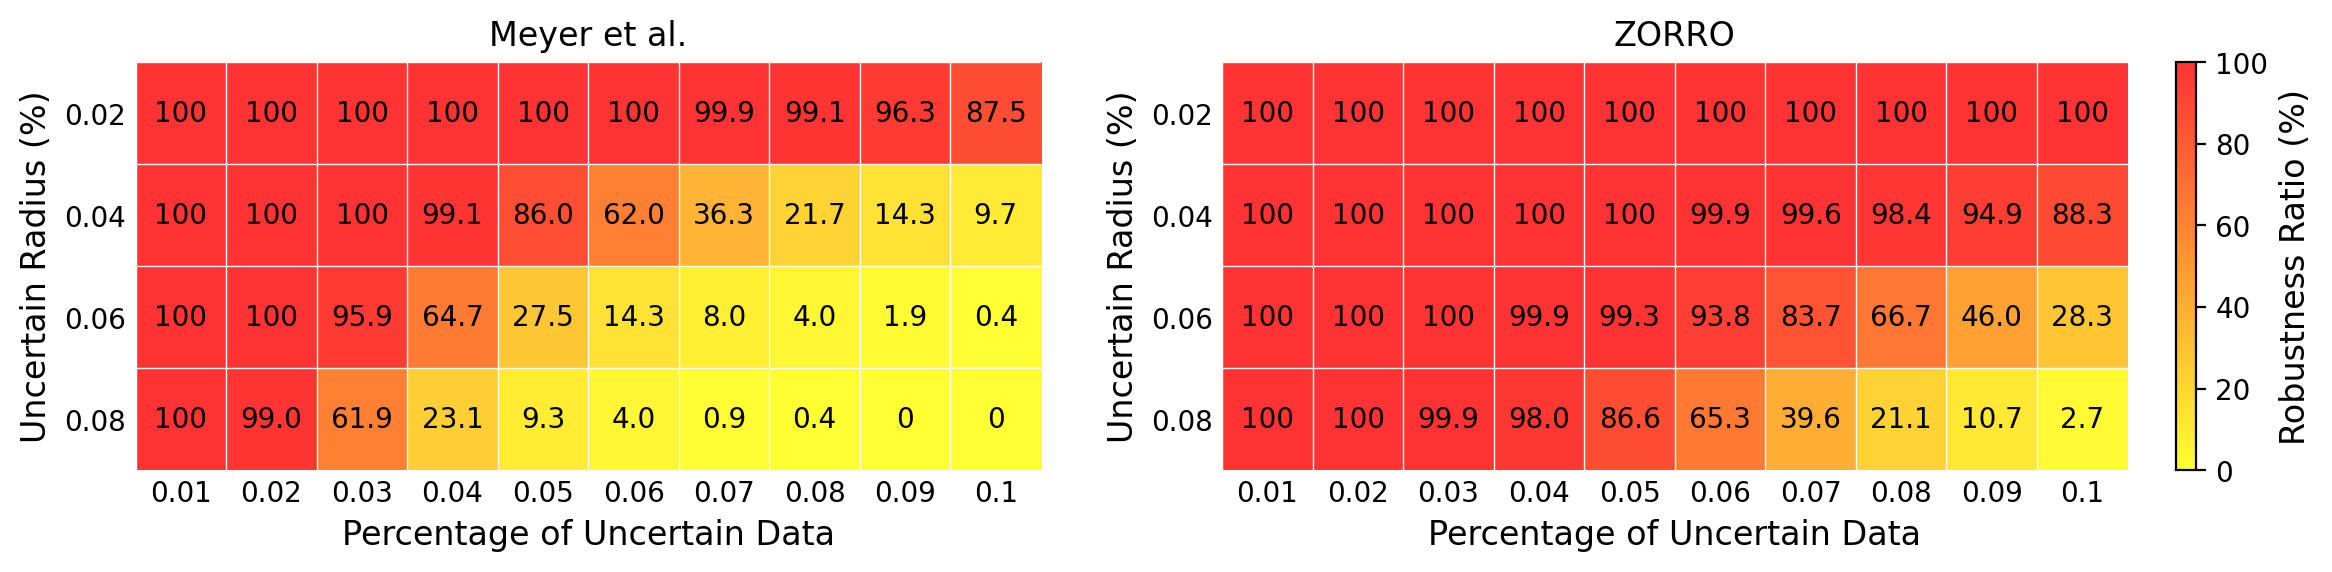

In [100]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.02, 0.04, 0.06, 0.08]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('ins-heatmap.pdf', bbox_inches='tight')

## Label error lineplot

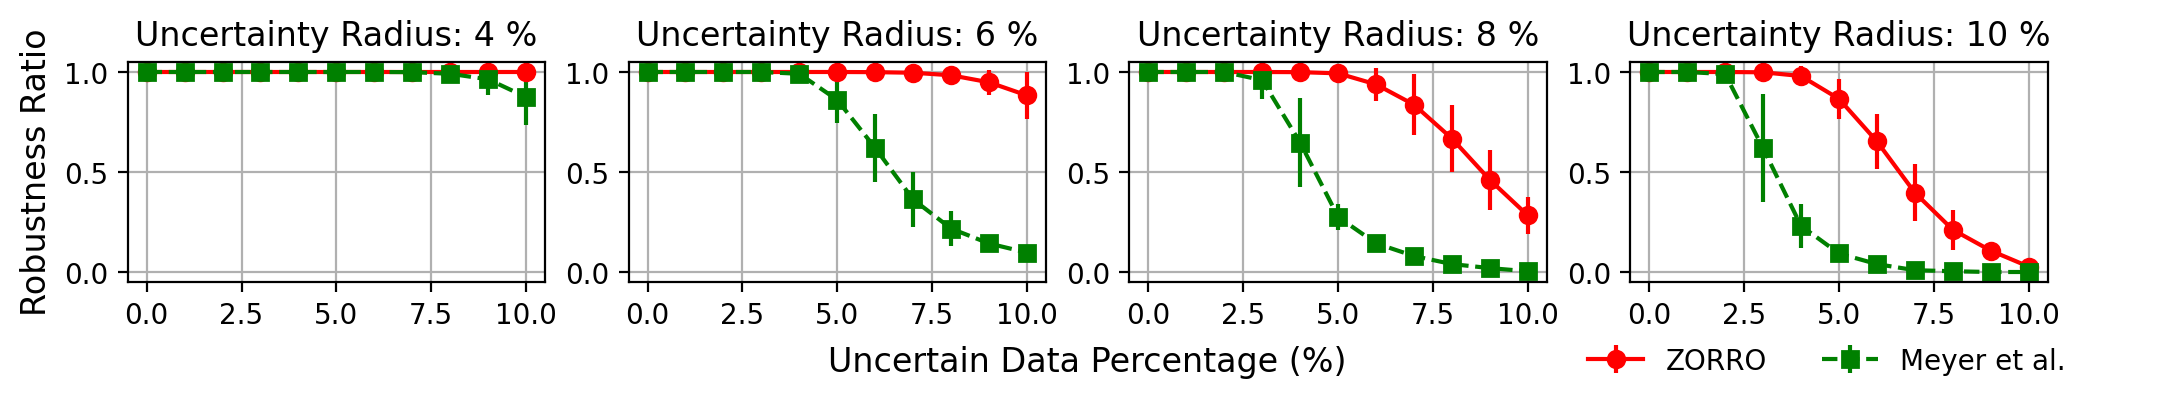

In [101]:
uncertain_pcts = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100
# uncertain_radius_ratios = [0.05, 0.10, 0.15, 0.2, 0.25]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

interval_data_mean_dict = dict()
interval_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    interval_data_mean_dict[radius_ratio] = np.append([1], robustness_interval_mean.iloc[i, :].to_numpy())
    interval_data_std_dict[radius_ratio] = np.append([0], robustness_interval_std.iloc[i, :].to_numpy())
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    axes[i].errorbar(uncertain_pcts, interval_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*interval_data_std_dict[uncertain_radius_ratio],
                     marker='s', color='green', label='Meyer et al.', linestyle='--')
    axes[i].set_title(f'Uncertainty Radius: {int(uncertain_radius_ratio*100)} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.73, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-labels-lineplot.pdf', bbox_inches='tight')

In [98]:
robustness_dicts = []
for seed in tqdm(range(5), desc=f'Progress'):
    robustness_radius = 100
    weight_interval = X_train.bmi.max()-X_train.bmi.min()
    uncertain_radius_ratios = [0.04, 0.06, 0.08, 0.1]
    uncertain_radiuses = [ratio*weight_interval for ratio in uncertain_radius_ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = uncertain_radius_ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius_ratio in tqdm(uncertain_radius_ratios, desc=f'Uncertain Data PCT: {uncertain_pct}', leave=False):
            robustness_ratio = compute_robustness_ratio(X_train, y_train, X_test, y_test, 
                                                        uncertain_attr='bmi', 
                                                        uncertain_num=uncertain_num, 
                                                        uncertain_radius_ratio=uncertain_radius_ratio, 
                                                        robustness_radius=robustness_radius)
            if robustness_ratio==0:
                trials_left = len(uncertain_radius_ratios)-uncertain_radius_ratios.index(uncertain_radius_ratio)
                for _ in range(trials_left):
                    robustness_dict[uncertain_pct].append(0)
                break
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Uncertain Data PCT: 0.01:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.02:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.03:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.04:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.05:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.06:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.07:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.08:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.09:   0%|          | 0/4 [00:00<?, ?it/s]

Uncertain Data PCT: 0.1:   0%|          | 0/4 [00:00<?, ?it/s]

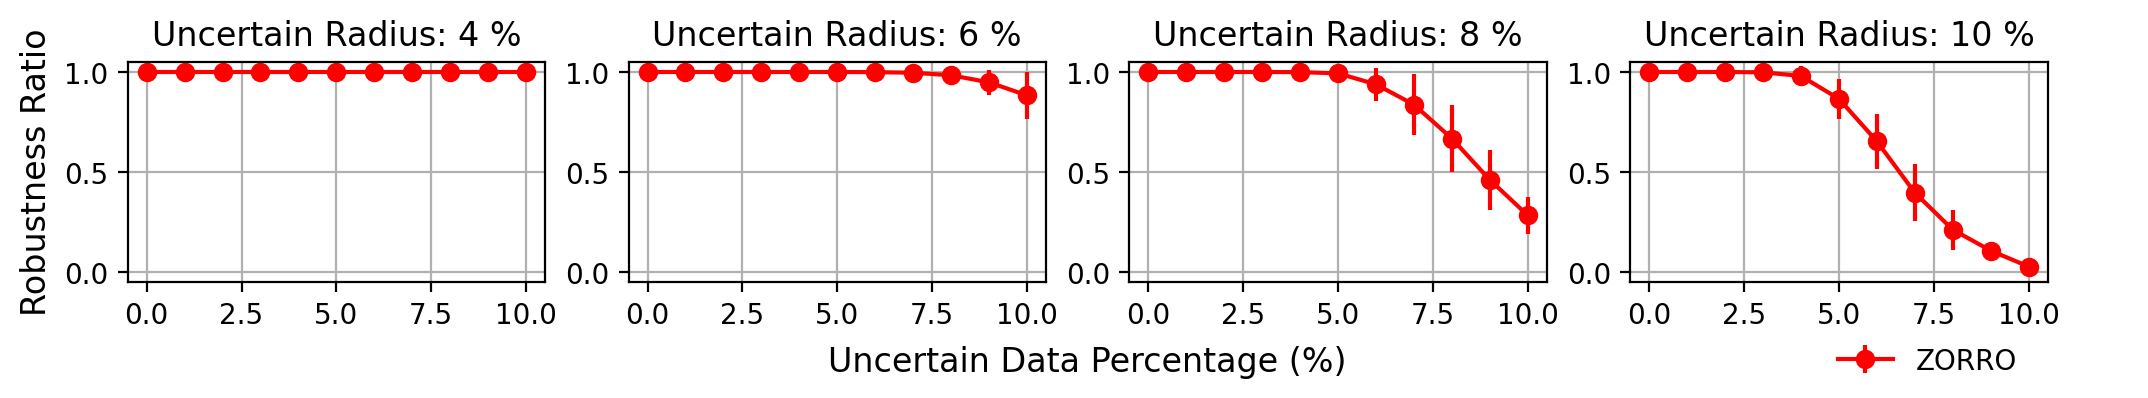

In [99]:
from matplotlib.ticker import FormatStrFormatter

uncertain_pcts = (np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])*100)
# uncertain_radius_ratios = [0.06, 0.08, 0.10, 0.12]

zonotope_data_mean_dict = dict()
zonotope_data_std_dict = dict()
for i, radius_ratio in enumerate(uncertain_radius_ratios):
    zonotope_data_mean_dict[radius_ratio] = np.append([1], robustness_zonotope_mean.iloc[i, :].to_numpy())
    zonotope_data_std_dict[radius_ratio] = np.append([0], robustness_zonotope_std.iloc[i, :].to_numpy())

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 2), sharex=True, dpi=200)

for i in range(4):
    uncertain_radius = uncertain_radiuses[i]
    uncertain_radius_ratio = uncertain_radius_ratios[i]
    axes[i].errorbar(uncertain_pcts, zonotope_data_mean_dict[uncertain_radius_ratio],
                     yerr=3*zonotope_data_std_dict[uncertain_radius_ratio],
                     marker='o', color='red', label='ZORRO', linestyle='-')
    radius_title = str(int(uncertain_radius_ratio*100))
    if uncertain_radius_ratio == 0.1:
        radius_title = '10'
    axes[i].set_title(f'Uncertain Radius: {radius_title} %')
    if i == 0:
        axes[i].set_ylabel('Robustness Ratio', fontsize=12)
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[i].grid(True)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = (0.85, 0.03), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.2, top=0.8, bottom=0.25, left=0.1, right=0.9)
fig.supxlabel('Uncertain Data Percentage (%)', fontsize=12, verticalalignment='bottom')
# plt.tight_layout()
# plt.show()
plt.savefig('ins-features-lineplot.pdf', bbox_inches='tight')